# Performing Sensitivity Analysis with NL4Py      

In this experiment, we perform sensitivity analysis using SALib on the Wolf Sheep Predation model via NL4Py. Two sensitivity analysis techniques are used, Sobol with Saltelli sampling and FAST as described in the article "NL4Py: Agent-Based Modeling in Python with Parallelizable NetLogo Workspaces" and results are compared. Additionally, SALib is run in parallel to improve performance and NetLogo HeadlessWorkspaces are run in parallel as well as Java threads on NL4Py's NetLogoControllerServer.

Start the NetLogoControllerServer

In [1]:
import nl4py
import sys
import os
import multiprocessing

from matplotlib import pyplot
import pandas as pd
import numpy as np
from matplotlib.pyplot import draw
from SALib.sample import saltelli
from SALib.analyze import sobol


nl4py.initialize("C:/Program Files/NetLogo 6.0.4")
model_path = "Models/Wolf Sheep Predation.nlogo"

Define what a simulation is. In this experiment, a simulation run is initialized with a parameter configuration, resets the model and runs it for 100 ticks. We perform the sensitivity analysis on the sheep, wolves, and grass version of the Wolf Sheep Predation model. We track the sheep and wolf populations over time as model output.

In [2]:
free_workspaces = []
for i in range(0,multiprocessing.cpu_count()):
    n = nl4py.create_headless_workspace()
    n.open_model('Wolf Sheep Predation.nlogo')
    free_workspaces.append(n)

def runForParameters(parameters):
    workspace = free_workspaces[0]
    free_workspaces.remove(workspace)
    workspace.command("stop")
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            workspace.command('random-seed {}'.format(parameters[i]))
        else:
            workspace.command('set {0} {1}'.format(name, parameters[i]))
    workspace.command('set model-version "sheep-wolves-grass"')
    workspace.command('setup')
    simulation_results = workspace.schedule_reporters(["ticks",'count sheep','count wolves'], 0,1,500,"go") 
    free_workspaces.append(workspace)
    aggregate_metric = calculate_population_stability(simulation_results)
    return aggregate_metric

Since the number of runs required would most likely far exceed the number of cores available, we define a function that makes sure we only run a number parallel NetLogoHeadlessWorkspaces equal to the number of cores on the machine for optimal performance.

We then iterate through the entire set of parameter configurations sampled from the product space and execute simulate(...) accordingly. The simulation output is obtained and aggregated into a final metric. 

In this experiment, we target <b>population equilibrium</b> (<a href="http://science.sciencemag.org/content/186/4164/645">May, 1974</a>). To quantify equilibrium we find the <b>population_stability</b> as the reciprocal of the derivatives of both populations over simulation time. The resulting <b>population_stabilities</b> are passed through a heavyside function to give a score of zero if populations that are equal to 0, (equilibria can exist both at extinction in addition to populations > 0). The <b>population_stability_total</b> is found as the mean <b>population_stability</b> over time between both species. Finally, the <b>aggregate_metric</b> scoring the simulation run is calculated as the mean <b>population_stability_total</b> over time.

In [3]:
def calculate_population_stability(simulation_results):
    ###Process simulation results###
    df = pd.DataFrame(simulation_results)
    sheep_pop = pd.to_numeric(df.iloc[:,1])
    wolves_pop = pd.to_numeric(df.iloc[:,2])
    #since time is in simulation ticks, this is the absolute rate of change of sheep population.
    dsheep_dt = sheep_pop.diff().abs()
    #since time is in simulation ticks, this is the absolute rate of change of wolf population.
    dwolves_dt = wolves_pop.diff().abs()   
    #Find population stabilities over time for species as reciprocal of derivatives multiplied by
    # a heavyside function ensuring extinction is scored at 0.
    population_stability_sheep = np.divide(1,(dsheep_dt + 0.000001)).mul(np.where(sheep_pop==0,0,1))
    population_stability_wolves = np.divide(1,(dwolves_dt + 0.000001)).mul(np.where(wolves_pop==0,0,1))
    #Find total population stability over time as the mean of population stabilities for both species.
    population_stability_total = (population_stability_sheep + population_stability_wolves) / 2
    #the aggregate metric is the mean, total population stability over time
    aggregate_metric = population_stability_total.sum()/len(population_stability_total)
    return aggregate_metric

Next, we use NL4Py to read in the parameters from the NetLogo model's interface and populate the problem space, required by SALib for sensitivity analysis, with both the names and ranges, automatically. 

In [4]:
ws = nl4py.create_headless_workspace()
ws.open_model("./Wolf Sheep Predation.nlogo")
#Read in the parameter info with NL4Py functions and generate a SALib problem
problem = { 
  'num_vars': 8,
  'names': ['random-seed'],
  'bounds': [[1, 100000]]
}
problem['names'].extend(ws.get_param_names()[:-2])
problem['bounds'].extend( [item[0::2] for item in ws.get_param_ranges()[:-2]])
print(problem)

{'num_vars': 8, 'names': ['random-seed', 'initial-number-sheep', 'sheep-gain-from-food', 'sheep-reproduce', 'initial-number-wolves', 'wolf-gain-from-food', 'wolf-reproduce', 'grass-regrowth-time'], 'bounds': [[1, 100000], [0.0, 250.0], [0.0, 50.0], [1.0, 20.0], [0.0, 250.0], [0.0, 100.0], [0.0, 20.0], [0.0, 100.0]]}


The simulation experiment is now defined. We can now run sensitivity analysis using techniques of our choice.
We choose to use <a href="http://salib.readthedocs.io/en/latest/">SALib</a>. 

First, we perform Sobol's sensitivity analysis using Saltelli's sampling sequence technique. <a href="https://www.sciencedirect.com/science/article/pii/S0378475400002706">(Sobol 2001)</a>,<a href="https://www.sciencedirect.com/science/article/pii/S0010465502002801">(Saltelli 2002)</a>,<a href="https://www.sciencedirect.com/science/article/pii/S0010465509003087">(Saltelli et al. 2010)</a>

In [5]:
from SALib.sample import saltelli
from SALib.analyze import sobol
param_values_sobol = saltelli.sample(problem, 200)
import multiprocessing
from multiprocessing.pool import ThreadPool
pool = ThreadPool(multiprocessing.cpu_count())
Y = np.array(pool.map(runForParameters, param_values_sobol))

In [6]:
import multiprocessing
Si_Sobol = sobol.analyze(problem, Y, print_to_console=True, parallel=True, n_processors=multiprocessing.cpu_count())

Parameter S1 S1_conf ST ST_conf
random-seed 0.033380 0.070077 0.088621 0.044434
initial-number-sheep 0.026127 0.112832 0.212765 0.106515
sheep-gain-from-food 0.083750 0.108539 0.181660 0.118332
sheep-reproduce 0.246515 0.189778 0.470969 0.208271
initial-number-wolves -0.000680 0.058320 0.128414 0.063967
wolf-gain-from-food 0.057697 0.095322 0.258740 0.127480
wolf-reproduce 0.386318 0.239738 0.618537 0.208634
grass-regrowth-time 0.010136 0.084231 0.215920 0.125574

Parameter_1 Parameter_2 S2 S2_conf
random-seed initial-number-sheep -0.021931 0.086203
random-seed sheep-gain-from-food -0.042475 0.082688
random-seed sheep-reproduce -0.094794 0.096740
random-seed initial-number-wolves -0.041857 0.087591
random-seed wolf-gain-from-food -0.034807 0.083846
random-seed wolf-reproduce -0.005443 0.093018
random-seed grass-regrowth-time -0.027383 0.084736
initial-number-sheep sheep-gain-from-food -0.005275 0.119722
initial-number-sheep sheep-reproduce -0.006814 0.173057
initial-number-sheep initia

Plot the first order Sobol sensitivity indices

[0.03338002 0.02612658 0.08375008 0.24651516 0.00068034 0.05769716
 0.38631767 0.01013627]
[0.03338002 0.02612658 0.08375008 0.24651516 0.00068034 0.05769716
 0.38631767 0.01013627 0.15539671]


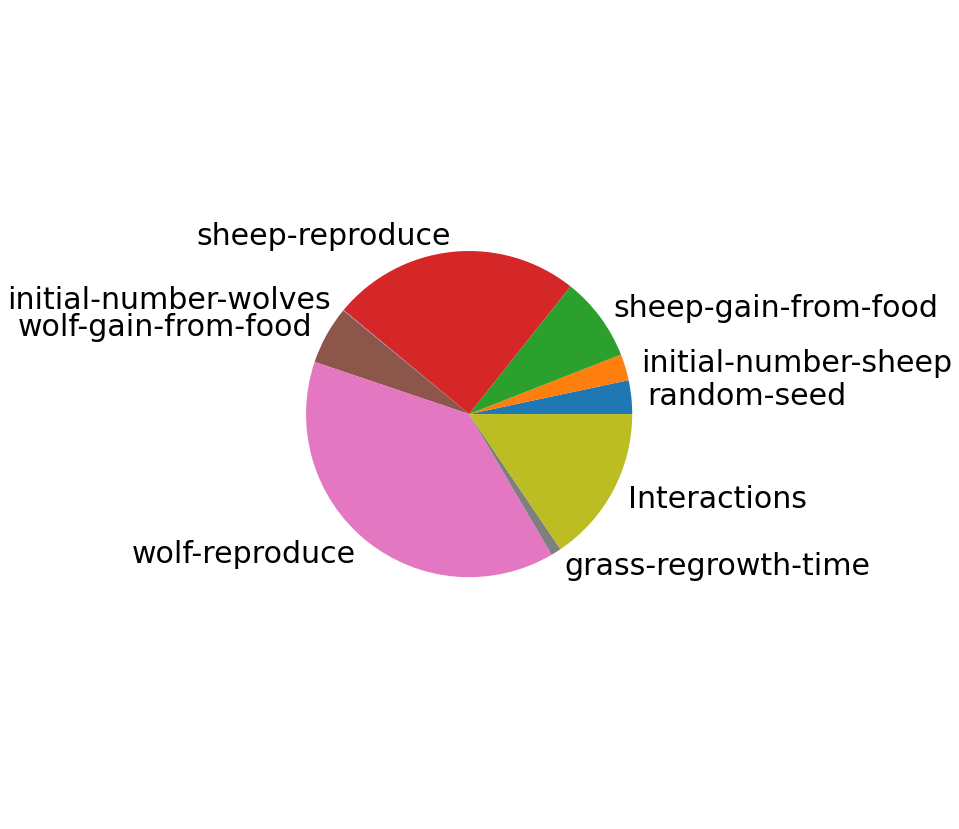

In [7]:
#Get the absolute values of the first order sobol sensitivity indices
sobol_s1_abs = np.abs(Si_Sobol["S1"])
print(sobol_s1_abs)
from matplotlib import pyplot
import matplotlib as mpl
mpl.rcParams['font.size'] = 30.0
#The residual of the first order sensitivity indicies represents the sensitivity caused by 
# higher order interactions of the parameters
S1_and_interactions_sobol = np.abs(np.append(sobol_s1_abs,(1 - sobol_s1_abs.sum())))
print(S1_and_interactions_sobol)
labels = np.append(problem['names'],'Interactions')
fig = pyplot.figure(figsize=[15, 15])
ax = fig.add_subplot(111)
plot = ax.pie(S1_and_interactions_sobol, labels = labels, labeldistance=1.1, startangle=0, radius=0.5)
fig.savefig('SobolWSPS1.png')

Plot the Sobol Total sensitivities to higher order interactions of parameters

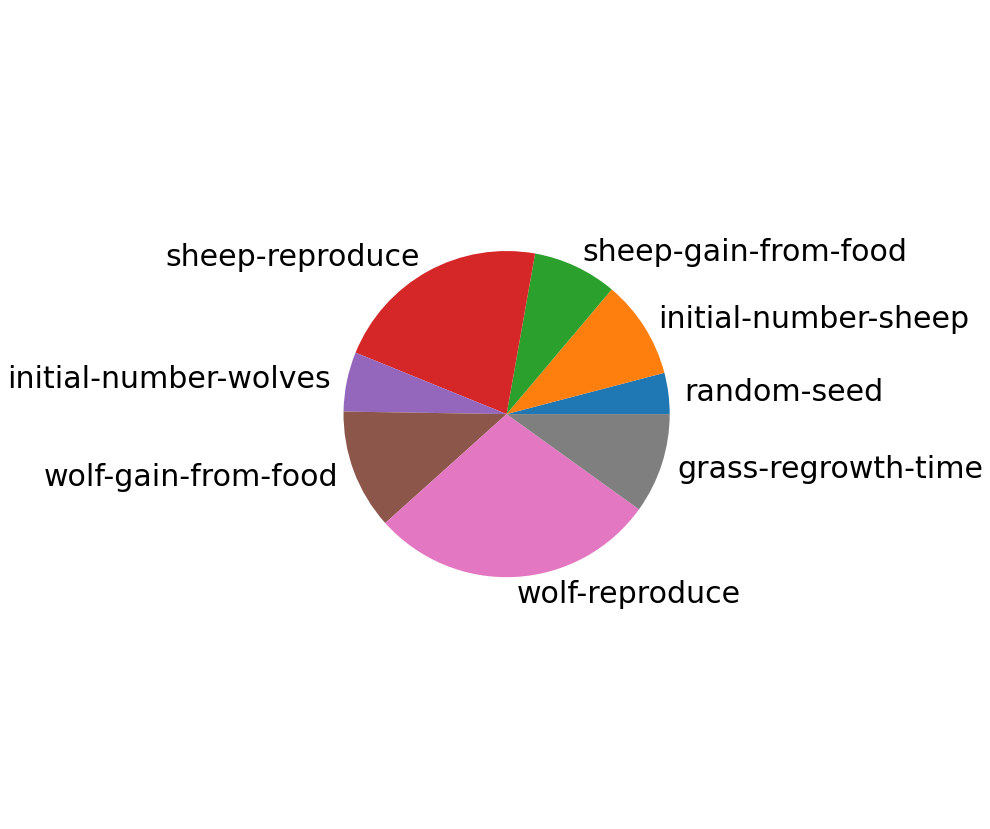

In [8]:
fig = pyplot.figure(figsize=[15, 15])
ax = fig.add_subplot(111)
plot = ax.pie(Si_Sobol["ST"], labels = labels[0:8], labeldistance=1.1, startangle=0, radius=0.5)
fig.savefig('SobolWSPST.png')

Next, run the Fourier Amplitude Sensitivity Test (FAST) sampling and sensitivity analysis technique <a href="https://aip.scitation.org/doi/abs/10.1063/1.1680571">(Cukier et al., 1973)</a>, <a href="https://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594#.WwiP3kgvyUk">(Saltelli et al., 1999)</a>.

In [ ]:
from SALib.analyze import fast
from SALib.sample import fast_sampler
nl4py.deleteAllHeadlessWorkspaces()
param_values_fast = fast_sampler.sample(problem, 1000)
Y_FAST = np.array(runForParameters(param_values_fast))